# 0. Intro to "web scraping" 🧑🏽‍💻

A primer to get us all on the same _page_.

## What is scraping? 🤷

Automating the steps of **gathering** information published on the internet and **processing** it into a convenient format for analysis.

 - 🧺 **Gathering**: Could be as simple as downloading the results of running a query on an API, or as complicated as simulating human interaction with a web form to "type" search parameters "click" the search button and save the results.
 - ✂️ **Processing**: Could be as simple as converting JSON to CSV, or as complicated as using CV to extract text from images and NLP to convert that text into tabular data.

## Why do we scrape? 🤨

We scrape because we have questions, but the dataset that could help answer these questions is missing.

Sometimes the dataset is intentionally missing.
Courts, for example, have databases full of tantalizing information for researchers and journalists, but they are notoriously stubborn about sharing it.
But they are often obligated to publish some amount of information on the internet, at least for a short time.
We can scrape the court websites to build our dataset.
This can help uncover, for example, the major players in consumer debt collection lawsuits and how prevalent they are.
 
Sometimes the data are piecemeal.
Often we need to collect data from multiple sources to find a more compelling story.
In the court data example, consumer debt is a _national_ issue and there simply doesn't exist one single national database of consumer debt lawsuits.
So we have to scrape one together ourselves.

Sometimes the data on the web just aren't formatted well.
This is less true today, but in the past many websites served static HTML, possibly without a database at all backing them up.
In order to use that data you'd need to download and format it.

## Alternatives to scraping 📠

Ideally, we **don't** scrape.

Scraping can be tedious and time-consuming.
Many websites use tactics to block programmatic access.
It's good to try other means of getting your underlying data first:

 - **Check if there's a "download" button.** In 2022, this has become much more common than in the past.
 - **Ask for access.** For non-sensitive / non-antagonistic projects the owners might be happy to provide you an export of their data. They likely have more and better data than you realized just by looking at the site.
 - **File a public records request.** This is a class unto itself, and it may not pan out the way you hope, but it's worth a shot going through the sanctioned channels.
 
Think of scraping as a scrappy, **last resort** method of getting your dataset, when nothing else works.

## Is scraping legal? 👀

[Yes! ✅](https://techcrunch.com/2022/04/18/web-scraping-legal-court/)

But! many websites actively discourage you, largely for three reasons:

1. **Data can be sensitive. 🙈** Keep this in mind whenever _you_ are scraping data, say from a court. You will have names and details about the court cases -- and just because this is technically "public" information doesn't mean it's widely known, and it can negatively impact individuals to be included in a dataset you build. Be mindful of and careful with personal information.
2. **The web isn't free. 💸** Web servers cost money and have finite resources. With human users, web servers are cheap and have ample resources. But even a simple scraping bot is capable of making _dozens_ of page requests _per second_. This spike in traffic can make the website unavailable for human users and can also balloon the cost of running the server.
3. **Data is gold. 💰** The business model of most big tech companies is to sell ~your~ their data.

Keep reasons (1) and (2) in mind as you scrape websites. Store your data ethically, censor and redact it where appropriate, and place a rate-limit on your scraping bot to keep the website available for others.

Do what you want with reason (3).

### What does "actively discourage" mean? 📵

Often, some form of CAPTCHA.
Your IP is also logged and subject to banning.
There are ways around these techniques, but we will not cover them here.

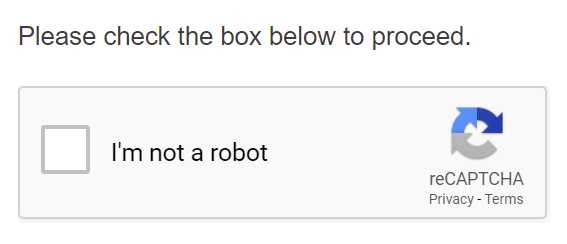!

# 1. Scoping the project 🔬

The first things to identify _before_ you start scraping are:
1. What's your question?
2. What data do you need to answer your question?
3. Where can you get this data?

For today's project, we're going to look at housing and evictions in San Francisco.

San Francisco is one of the most [expensive](https://www.dbresearch.com/PROD/RPS_EN-PROD/PROD0000000000494405.pdf?undefined&realload=IfbV/lNZWzJUGuuE7hHWFmrrGl3IRC7Wm1wixcHx0ltY2AZL6G3khovJo4kh22HV) rental markets in the world.
People often point to the basics of supply and demand to explain this: there aren't enough rental units.
While there are certainly multiple reasons why rental supply is limited, one housing law that's drawn a lot of criticism is known as the [_Ellis Act_](https://sftu.org/ellis/).

While California (and San Francisco in particular) typically has strong protections for tenants, under Ellis, landlords can unconditionally evict tenants if they are taking the building out of the rental market.
The law was intended to give landlords an out if they wanted to, say, have a family and stop renting out their downstairs unit.

However, there is a suspicion that real estate speculators have started abusing Ellis to take rental units off the market and flip them as houses.


### Question 🙋🏽

How has the Ellis Act been used in San Francisco to limit housing rental supply?

_Big question! We will only be able to begin to address this in this workshop!_


### What data do we want? 📀

Today, we will start by gathering only one statistic:

 - How many evictions have been filed under the Ellis Act
 
To follow up on this work, we'd want to see also:

 - Who has been filing the Ellis Act? (single homeowners? corporate investors?)
 - What are the addresses of units that have been Ellised? (what neighborhoods is this happening in? what are the demographics of people who are being evicted? does Ellis disproportionately impact renters of color?)
 - What's the transaction timeline of the houses in question? (how long was the unit owned before Ellising? 10 months? 10 years?)
 
### Where can we get data? 🌎

Today we will look at:

 - 🏠 The [SF Rent Board](https://sfrb.org/monthly-statistics) publishes monthly statistics, including how many units have been Ellised
 
In the future we might also want to see data from:

 - 💸 The [SF Assessor/Recorder](https://sfplanninggis.org/pim/?pub=true), who track information about property ownership for tax purposes, including who owns the property and what the property is used for.


## 1.2. Checking out the site 🕵🏼‍♀️

So today we will get data the SF Rent Board.

Let's check out their statistics site: https://sfrb.org/monthly-statistics

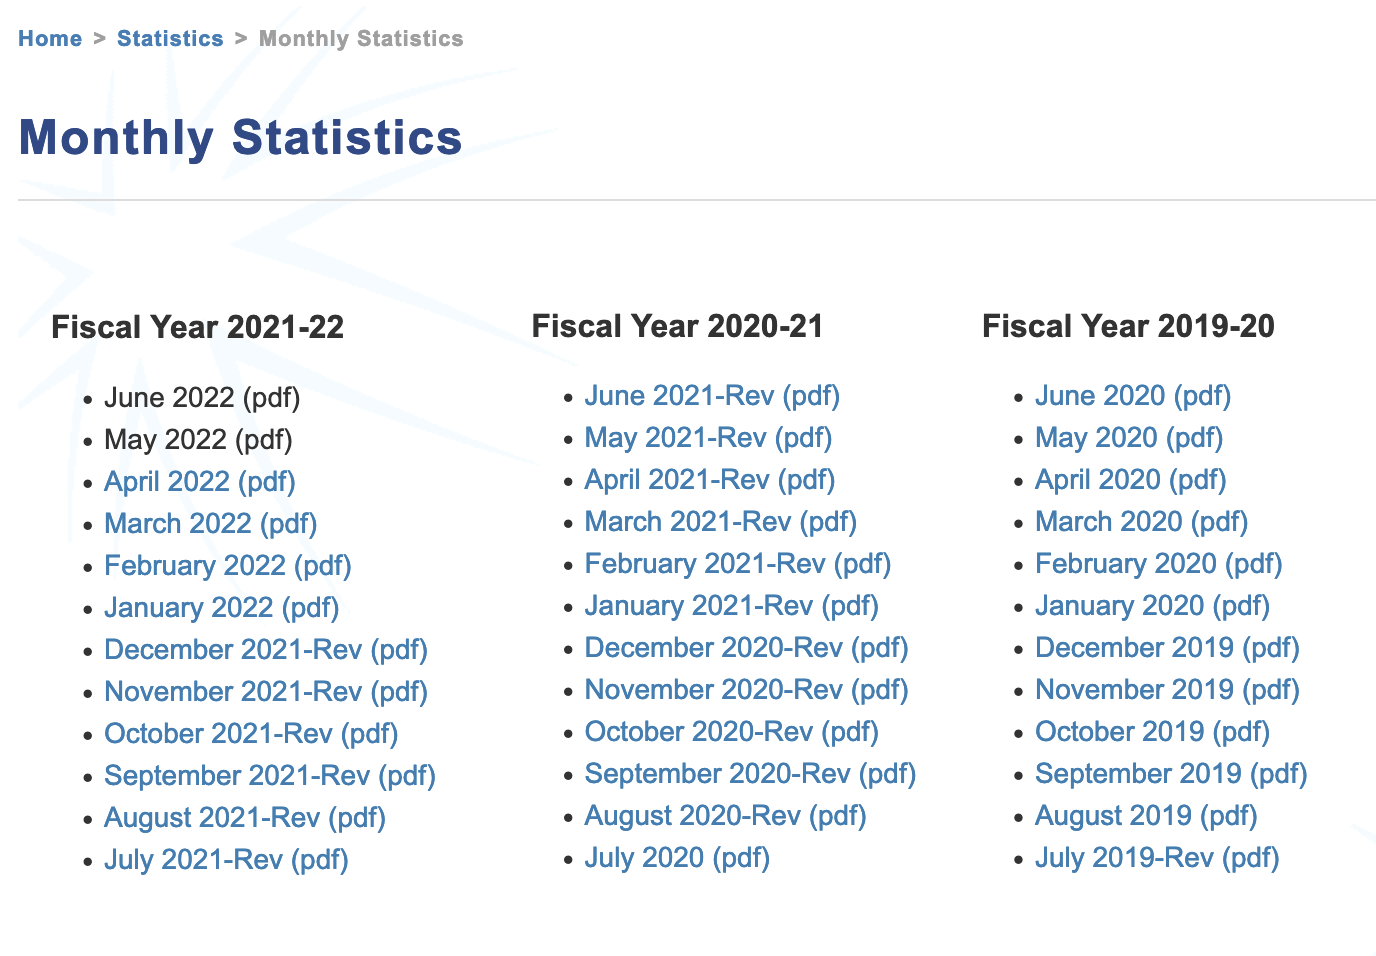

Cool, about 20 years of data!!
Let's check out what format it's in. Click on one of the links, like: https://sfrb.org/sites/default/files/Workload%20Stats%20April%202022.pdf

_Gahhh, a PDF!_ 😢

Well, the good news is this form contains an _Ellis_ field, and it looks like it's been filled in every month since ... 2003?

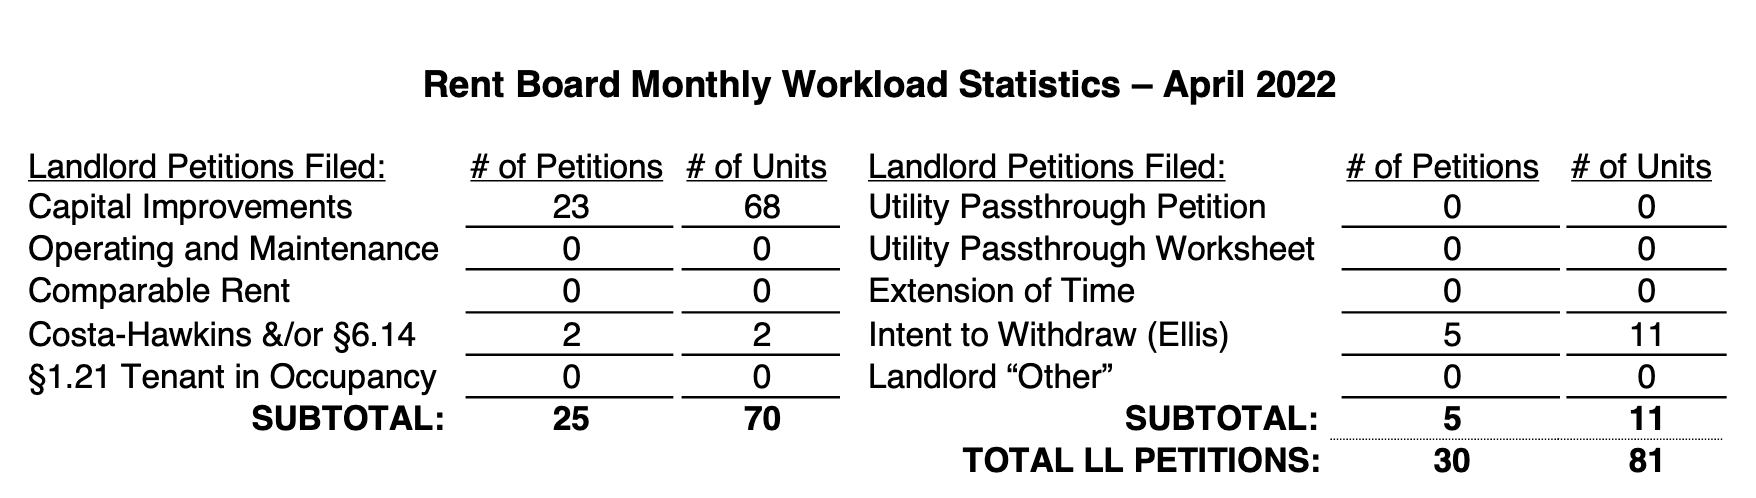

Looks like from 2000-02 they actually published this in HTML! 🙃

### Sometimes there are easier ways 🛋

For this site, we're going to have to extract data from PDFs.
No way around it.

For newer sites, it's worth checking the "Network" tab in your browser - there may be a query API "under the hood" that you can interact with directly, without having to process HTML.

# 2. Setting up your environment 🧑🏽‍💻

Python seems like a good choice here.
For highly dynamic websites in which you have to simulate "human" behavior, it's often easier to write scrapers in JavaScript.
But for this project, the Python code will end up being simpler and cleaner.

We'll install a few packages to help:

### [`requests`](https://requests.readthedocs.io/en/latest/)

Python includes built-in libraries to make HTTP requests, but they are very _low-level_, meaning they have lots of options and tend to be tedious to use. Most people use a library called `requests` to simplify this process.

### [`beautifulsoup4`](https://www.crummy.com/software/BeautifulSoup/) 🍜

There are many ways to process HTML. BeautifulSoup is a library developed specifically for scraping web-pages. It is able to parse messy (and potentially invalid) HTML and provides flexible ways to query for information in the parsed document.

### [`PyPDF2`](https://pypdf2.readthedocs.io/en/latest/)

Python does not include a built-in way to work with PDF files, so we use this 3rd-party library to help.

In [ ]:
pip install requests beautifulsoup4 PyPDF2

# 3. Scraping the index 📇

Time to start scraping!

Our first goal is to get a list of all the documents that contain the information we want.
Very commonly when scraping websites, we run into this kind of "index" page that contains links to the actual content.
On the SFRB site, this actual content is (mostly) in the form of PDFs.

### Index scraping goals: 💪🏼
1. Fetch the HTML of the "index" page 
2. Find links to every PDF containing housing data
3. Download PDFs

## 3.1. Fetch the index page 🐶

Use `requests` to download the HTML of the index page.

In [ ]:
URL = "https://sfrb.org/monthly-statistics"

In [ ]:
# Uncomment the following line to see the solution.
# %load solutions/3_1_fetch_index.py

# Goal: Use the `requests` library to fetch the `monthly-statistics` URL

That was easy! but ... what a **_soup!_** 🍜

## 3.2. Find PDF links 🔎

All that HTML is going to be a pain to sift through.
This is where BeautifulSoup comes in handy.

Let's take a look at some tools `BeautifulSoup` gives us.

In [ ]:
# Import the `BeautifulSoup` class.
# Note that `beautifulsoup4` installs itself as `bs4` so you don't have to type as much.
from bs4 import BeautifulSoup

# Creating a `BeautifulSoup` object will parse the HTML.
response = requests.get(URL)
soup = BeautifulSoup(response.text)

# Now `soup` has a few methods for interacting with the parsed HTML.

In [ ]:
print("Query for all the `h1` elements:\n")
print(soup.find_all('h1'))

In [ ]:
print("Query for all the elements with a `block-title` class:\n")
print(soup.select('.block-title'))

In [ ]:
print("Extract the text content of all the `.block-title` elements:\n")
for el in soup.select('.block-title'):
    print(el.text)

`BeautifulSoup` has *lots* more features you may need at some point. For now, let's just find the PDF links.

Using the "inspect" tool in your browser, you want to figure out: what makes the links I'm interested in _unique_, compared with any other link on the page?

In [ ]:
# Way too broad!
soup.select('a')

In [ ]:
# This is better, but still too broad ...
soup.select('li a')

In [ ]:
# Even better, but what about those non-PDF links?
soup.select('table li a')

In [ ]:
# This is actually too narrow because they used a CMS at some point!!!
soup.select('a[href*=pdf]')

In [ ]:
# Uncomment the following line to the see the solution.
# %load solutions/3_2_find_pdf_links.py

# Goal: find the links to all the PDFs -- nothing more, nothing less!
# Hint: what do all the links share that nothing else on the page has?
pdf_links = ...

Hoorah! ✅ Now we want to make a `dict` of file names to URL paths.
We will use this dictionary to save each URL as a local file with the given name.

In [ ]:
# If we just try something naive, we notice a few problems ...
urls = {a.text: a['href'] for a in pdf_links}
print(urls)

In [ ]:
# Uncomment the following line to the see the solution.
# %load solutions/3_2_name_links.py

# Goal: create a `dict` of file names to URL paths.
# Hints:
#  1) How do we clean up the file names?
#  2) What's wrong with the links and how do we fix them?

## 3.3. Download the PDFs 💾

Now we just need to loop through the PDF links and save them.

Remember, we are going to make over 200 requests to the server to download documents.
This is a red flag to see this burst of activity from one IP address.
It's very possible they will ban your IP automatically.
It's also possible for you to degrade performance for other users.

You can mitigate this by spacing out your requests a bit, using the `time` module's `sleep` function. 😴

In [ ]:
# Uncomment the following line to the see the solution.
# %load solutions/3_3_download_pdfs.py

# Goal: download all of the URLs in the `urls` object.
# Hints:
#  1) Use the keys of `urls` dictionary as the name of each file
#  2) Save all the files into the `raw/` directory
#  3) You will need to write your file using `binary` mode, since PDFs
#     are binary data!
#  4) Use `time.sleep` to wait 0.25 seconds between requests

# 4. Parsing the PDFs ✂️

Now that we have the PDFs, it's time to process them, similarly to how we processed the index page.

`BeautifulSoup` worked great for the HTML, but it won't work for PDFs.
Instead, we will use a library called `PyPDF2`.

The goals for this step are:
1. Extract text from the PDFs
2. Parse Ellis filings from the extracted text
3. Create a CSV file with Ellis info by date


## 4.1. Extracting text from PDFs 💬

Let's look at what the PyPDF2 library gives us.

In [ ]:
from PyPDF2 import PdfFileReader

reader = PdfFileReader(os.path.join('raw', 'April 2022.pdf'))

In [ ]:
# The PDF contains some metadata about its creation.
print("Metadata:")
for key, value in reader.documentInfo.items():
    print(f"  {key}: {value.get_object()}")

In [ ]:
# It also can tell us how many pages it has:
print(f"Pages: {reader.getNumPages()}")

In [ ]:
# There's a lot more information that can be helpful, but let's
# just look directly at the text of that single page in the document:
text = reader.getPage(0).extract_text()
print("Text:")
print(text)

More soup! 🍜🍜

## 4.2. Extracting Ellis filings 🔢

The text is kind of messy, but hey, we can see the word "Ellis" and some numbers.
That's very promising!

We can write a **regular expression** to extract the two numbers after we see the word "Ellis."

### Regular expressions 😐

A way to describe patterns in strings. You can use them to find information in text.

Your pattern usually includes a mix of _literal_ and _special_ characters.

For example, if you saw the text `hayneedlestack` you might use the literal pattern `needle` to find the word `needle` inside the `haystack`.

You could also use a pattern with special characters.
The pattern `ne+dle` matches `n` followed by one or more `e`s followed by `dle`.
So it would not only match `hayneedlestack`, but also `haynedlestack` and `hayneeeeeeeeeeeeeeedlestack`.

Another example is the pattern `n\w+e`, which matches `n` followed by one or more alphabetic characters (like, a, b, c, d, ..., and so on) followed by the letter `e`.
So it would match not only `hayneedlestack` but also `haynoodlestack` and `haynicestack`.

There are lots of special characters that can help you write sophisticated patterns. This is a good tutorial: https://regexone.com/

You can also use a visual RegEx tester such as https://regex101.com/ to help understand and debug your patterns.

In [ ]:
# Uncomment the following line to the see the solution.
# %load solutions/4_2_ellis_regex.py

# Goal: Write a regular expression that can locate the two numbers in the document
#       that are reported on the "Ellis" line.
# Hints:
#  1) Use raw strings to write your pattern, e.g. r'my-pattern'
#  2) Use capturing groups to extract these numbers

# Note: Compiling the pattern in advance is good practice, but not necessary.
ellis_pattern = re.compile(...)

Compare this to what we see in the "April 2022.pdf" document.
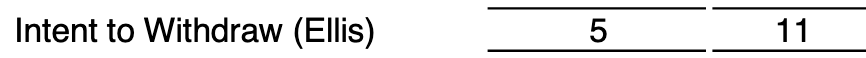

**Scaling up** 📈

Now lets loop through all the documents and run this pattern.

In [ ]:
# Uncomment the following line to the see the solution.
# %load solutions/4_2_ellis_extract.py

# Create a dictionary to store the results of our extraction.
ellis_data = {}

# Goal: Run the regex pattern on all the PDFs to extract the Ellis numbers
#       and store the results in the `ellis_data` dictionary.
# Hint: The results should look like `{"April 2022": ["5", "11"]}`.

Now it's looking a lot like the dataset we were seeking!!

## 4.3. Saving results 💾

People usually save data as CSV files.
These are simple and portable.
You can share a CSV and immediately open it in Excel, Google Sheets, Apple Numbers, Python, R, or any old text editor.

**hot take** 😤

The downside of CSV is that it does not store any explicit _type_ information.
So, if your data contains numbers, dates, null values, and so on, you (and anyone you give the data to) will have to figure that out themselves when they open the file.

I personally feel it's more useful to use a structured data format such as parquet, sqlite, or even JSON.

But for now, we will just use CSV.



In [ ]:
# Uncomment the following line to the see the solution.
# %load solutions/4_3_save_csv.py

# Goal: Save `ellis_data` as `data/ellis.csv` with four columns: `year,month,petitions,units`.
# Hints:
#  1) Python comes with a `csv` library, though you don't necessarily need to use it.
#  2) Remember you'll need to parse the month and year from the file name into separate columns!

**_Now open `data/ellis.csv` and behold: tabular data!!_**

# 5. Working with the data 👷🏽‍♀️

The scraping project is officially **done**, but we might as well take a look at what we found!
We have all sorts of power now that we have this table.
Let's just try to do a few basic things:

1. Read data from the CSV
2. Tally how many units have been taken off the market via the Ellis Act in our data
3. Make a chart of Ellis petitions over time

## 5.1. Reading the CSV 📖

Reading the CSV is even easier than writing it, though, again we need to be careful about our data types.
We know that we're working with integers and we don't have any missing values, so we'll convert the columns here.

In a larger analysis project you would want to use a fully-featured library like `pandas`.


In [ ]:
# Uncomment the following line to the see the solution.
# %load solutions/5_1_read_csv.py

# Goal: Load your dataset from `data/ellis.csv`.
# Hint: Each row in the CSV should become a dictionary with values for each column.
data = []

## 5.2. Math! ➕✖️🟰

In [ ]:
# Uncomment the following line to the see the solution.
# %load solutions/5_2_math.py

# Goal: Answer a few simple questions using the data!
#  1) How many total Ellis petitions were filed in the dataset?
#  2) How many total units were subject to the Ellis Act in the dataset?
#  3) What's the average number of units withdrawn by each Ellis petition?
#  4) How many petitions were filed each year in the dataset?

## 5.3. Visualization! 📊

Looking at petitions by year in a table is interesting, but it would be easier to make sense of in a chart.

We'll use a charting library called `matplotlib`.

Matplotlib uses _columns_ of data instead of _rows_.
When you have a list of dictionaries representing rows (as we do), your data is said to be **row-oriented**.
A **column-oriented** (or, **columnar**) dataset would be a list of lists, where each list represents a column.

_**Most data analytics tools prefer column-oriented data for performance reasons! 🏎💨**_

This technique of working with columnar data is often called **vectorization**.

In [ ]:
pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt

# We can make a really quick plot by year, since we already have the data.
ordered_petitions = [petitions_by_year[year] for year in ordered_years]
plt.plot(ordered_years, ordered_petitions)

In [ ]:
# Uncomment the following line to the see the solution.
# %load solutions/5_3_viz.py

# Goal: Separate your dataset into three columns:
#   1) Time: for each row, turn (year,month) into a `datetime` object in Python.
#   2) Petitions: you can use this column unchanged
#   3) Units: you can use this column unchanged

In [ ]:
# Uncomment the following line to the see the solution.
# %load solutions/5_3_plots.py

# Goal: Plot number of petitions and number of units over time.